In [1]:
%%capture
!pip install transformers trl accelerate torch bitsandbytes peft datasets -qU

In [2]:
%%capture
!pip install flash_attn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [108]:
import os
import torch
from datasets import Dataset
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer

In [109]:
# Model from Hugging Face hub
# base_model = "meta-llama/Llama-2-7b-chat-hf"
base_model = "mistralai/Mistral-7B-Instruct-v0.2"
# base_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"
#base_model = "meta-llama/Meta-Llama-3-8B-Instruct"

# Fine-tuned model
# new_model = "/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/mistral/" + base_model.split("/")[-1]
new_model = "/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/mistral_with_weak_labels/" + base_model.split("/")[-1]

In [263]:
#dataset
df = pd.read_csv("content/train_data.csv")

# Load the weak labels dataset
weak_df = pd.read_csv("content/train_data_weak_labels.csv")

In [264]:
df.shape
weak_df.shape

(10154, 3)

In [271]:
def create_prompt(statement1, statement2):
  system_message = """<s>[INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.[/INST]""".format(statement1, statement2)

  # system_message = """You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.""".format(statement1, statement2)

  full_prompt = ""
  full_prompt += system_message

  return full_prompt

def create_label(relationship):
  response = f"{relationship}</s>"

  return response



In [514]:
df['instruction_prompt'] = df.apply(lambda row: create_prompt(row['text1'], row['text2']), axis=1)
df['label']  = df.apply(lambda row: create_label(row["divergent_or_not_divergent"]), axis=1)
df['weight'] = 1  # Strong labels have weight 1

# weak_df['instruction_prompt'] = weak_df.apply(lambda row: create_prompt(row['text1'], row['text2'], row["divergent_or_not_divergent"]), axis=1)
weak_df['instruction_prompt'] = weak_df.apply(lambda row: create_prompt(row['text1'], row['text2']), axis=1)
weak_df['label']  = weak_df.apply(lambda row: create_label(row["divergent_or_not_divergent"]), axis=1)
weak_df['weight'] = 0.5  # Weak labels have a lower weight say 0.5

weak_df = weak_df.sample(n=3000, random_state=42)

In [515]:
df.head()

,text1,text2,divergent_or_not_divergent,instruction_prompt,label,weight
0,Formulation of genetically modified food endan...,Genetically modified food is often subject to ...,divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1
1,Formulation of genetically modified food endan...,Many of the processes employed in genetic modi...,divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1
2,Tilling is not a hard requirement for farming ...,"Conventional tilling, needed to keep non-GM cr...",divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1
3,Use of the herbicide glyphosate has dramatical...,Multiple studies linking glyphosate to numerou...,divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1
4,The recent rise in celiac disease correlates w...,While the study referenced above touches on po...,divergent,<s>[INST]You are given a task to find if the g...,divergent</s>,1


In [516]:
weak_df.head()

,text1,text2,divergent_or_not_divergent,instruction_prompt,label,weight
1501,Most farmed animals live miserable lives on fa...,Farming vegetarian products also directly or i...,Divergent,<s>[INST]You are given a task to find if the g...,Divergent</s>,0.5
2586,Time loses value when it is limitless rather t...,Life would lose all its value if it never ended.,Not Divergent,<s>[INST]You are given a task to find if the g...,Not Divergent</s>,0.5
2653,"Every decision is determined by one's beliefs,...","If this were true, psychologists could predict...",Divergent,<s>[INST]You are given a task to find if the g...,Divergent</s>,0.5
1055,Crops provide us with important minerals that ...,"By eating meat, people can satisfy their miner...",Not Divergent,<s>[INST]You are given a task to find if the g...,Not Divergent</s>,0.5
705,This is a slippery slope argument: the connect...,Enforcing the use of preferred pronouns is lik...,Divergent,<s>[INST]You are given a task to find if the g...,Divergent</s>,0.5


In [517]:
df.shape
weak_df.shape

(3000, 6)

In [518]:
# Combine the two datasets
combined_df = pd.concat([df, weak_df], ignore_index=True)

In [519]:
combined_df.shape

(3257, 6)

In [520]:
print(new_model)

/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/mistral_with_weak_labels/Mistral-7B-Instruct-v0.2


In [521]:
tds = Dataset.from_pandas(combined_df[['instruction_prompt', 'label', 'weight']])
tds

Dataset({
    features: ['instruction_prompt', 'label', 'weight'],
    num_rows: 3257
})

In [522]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

In [497]:
!pip install huggingface_hub

from huggingface_hub import notebook_login

notebook_login()

In [523]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map='auto',
    attn_implementation="flash_attention_2"
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [524]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [525]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    task_type="CAUSAL_LM"
)

In [526]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [527]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    print(torch.cuda.device_count())
    model.is_parallelizable = True
    model.model_parallel = True

In [528]:
args = TrainingArguments(
  output_dir = "/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/mistral_with_weak_labels",
  num_train_epochs=10,
  per_device_train_batch_size = 12,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  evaluation_strategy="no",
  learning_rate=2.5e-5,
  bf16=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [529]:
class WeightedSFTTrainer(SFTTrainer):

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        weights = inputs.pop("weight")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Shift logits and labels for next token prediction
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        # Compute the loss
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        # Debugging: Print shapes
        # print(f"shift_logits shape: {shift_logits.shape}")
        # print(f"shift_labels shape: {shift_labels.shape}")
        # print(f"loss shape: {loss.shape}")
        # print(f"weights shape: {weights.shape}")

        # Expand weights to match the flattened loss tensor
        expanded_weights = weights.view(-1, 1).repeat(1, shift_labels.size(1)).view(-1)
        weighted_loss = (loss * expanded_weights).mean()
        # expanded_weights = weights.view(-1, 1).expand(loss.size(0) // weights.size(0), weights.size(0)).contiguous().view(-1)
        # weighted_loss = (loss * expanded_weights).mean()

        return (weighted_loss, outputs) if return_outputs else weighted_loss

    def get_train_dataloader(self):
      train_sampler = self._get_train_sampler()
      return torch.utils.data.DataLoader(
          self.train_dataset,
          batch_size=self.args.train_batch_size,
          sampler=train_sampler,
          collate_fn=self.data_collator,
          drop_last=self.args.dataloader_drop_last,
          num_workers=self.args.dataloader_num_workers,
      )


In [530]:
def calculate_max_length(dataset, tokenizer):
    max_length = 0
    for i in range(len(dataset)):
        prompt = dataset['instruction_prompt'][i]
        tokens = tokenizer(prompt, return_tensors='pt')
        max_length = max(max_length, tokens.input_ids.size(1))
    return max_length

max_length = calculate_max_length(combined_df, tokenizer)
print(f"Maximum length of input prompts: {max_length}")

Maximum length of input prompts: 529


In [531]:
def tokenize_function(examples):

  # Get the instruction_prompt column from the examples
  instruction_prompts = examples['instruction_prompt']
  labels = examples['label']

  # input_tokens = tokenizer(examples['instruction_prompt'], padding='max_length', max_length=max_length_input, truncation=True, return_tensors='pt')
  input_tokens = tokenizer(
        examples['instruction_prompt'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
  )

  # label_tokens = tokenizer(examples['label'], padding='max_length', max_length=max_length_labels, truncation=True, return_tensors='pt')
  label_tokens = tokenizer(
        examples['label'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
  )

  # The labels should align with the input
  labels = label_tokens['input_ids']

  # Replace padding token id by -100 to ignore them in loss computation
  labels[labels == tokenizer.pad_token_id] = -100

  # Create a new dictionary with the desired keys and values
  output = {

      'input_ids': input_tokens['input_ids'],
      'attention_mask': input_tokens['attention_mask'],
      'labels': labels,
      'weight': torch.tensor(examples['weight'], dtype=torch.float32)
  }

  # Debugging: Print shapes to verify batch sizes
  print(f"input_ids shape: {output['input_ids'].shape}")
  print(f"labels shape: {output['labels'].shape}")

  return output

In [532]:
tokenized_datasets = tds.map(tokenize_function, batched=True, remove_columns=['instruction_prompt', 'label'])


Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

input_ids shape: torch.Size([1000, 512])
labels shape: torch.Size([1000, 512])
input_ids shape: torch.Size([1000, 512])
labels shape: torch.Size([1000, 512])
input_ids shape: torch.Size([1000, 512])
labels shape: torch.Size([1000, 512])
input_ids shape: torch.Size([257, 512])
labels shape: torch.Size([257, 512])


In [533]:
tokenized_datasets

Dataset({
    features: ['weight', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3257
})

In [534]:
# Verify tokenization
print(tokenized_datasets.column_names)
print(tokenized_datasets[1])

['weight', 'input_ids', 'attention_mask', 'labels']
{'weight': 1.0, 'input_ids': [1, 1, 733, 16289, 28793, 1976, 460, 2078, 264, 3638, 298, 1300, 513, 272, 2078, 5964, 302, 12908, 460, 19002, 6188, 442, 459, 28723, 1263, 2757, 28725, 272, 6251, 464, 3912, 22512, 2130, 13857, 271, 313, 352, 659, 750, 264, 12598, 2038, 298, 4916, 2528, 354, 754, 28705, 28787, 28734, 1267, 1815, 304, 464, 966, 964, 14838, 302, 13857, 271, 547, 28705, 594, 297, 11605, 2130, 659, 7087, 2528, 6092, 1815, 460, 264, 5964, 302, 19002, 6188, 12908, 1096, 272, 4494, 3582, 28714, 8137, 2130, 13857, 271, 313, 352, 390, 264, 5023, 2038, 298, 4916, 798, 2528, 14349, 272, 9827, 27314, 1291, 272, 938, 302, 14826, 2235, 390, 11454, 14826, 547, 28705, 594, 506, 1276, 28712, 15402, 2528, 6092, 28723, 4003, 349, 1698, 2757, 28747, 272, 12908, 464, 5839, 1327, 298, 272, 13857, 28725, 272, 3168, 4338, 354, 27461, 28733, 28740, 28774, 6883, 403, 1215, 1486, 1815, 304, 464, 28769, 326, 663, 5461, 2045, 302, 27461, 28733, 28740

In [535]:
class DataCollatorForWeightedLanguageModeling(DataCollatorWithPadding):
    def __call__(self, features):
        # print("Features before collating:", features)  # Debug print
        weights = torch.tensor([feature['weight'] for feature in features], dtype=torch.float32)
        for feature in features:
            feature.pop('weight')
        batch = super().__call__(features)
        batch['weight'] = weights
        # print("Batch after collating:", batch)  # Debug print
        return batch


In [536]:
data_collator = DataCollatorForWeightedLanguageModeling(tokenizer)

In [537]:
trainer = WeightedSFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    peft_config=peft_config,
    dataset_text_field="instruction_prompt",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=args,
    packing=False,
    data_collator=data_collator
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [538]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,0.041700
20,0.029700
30,0.027600
40,0.025500
50,0.023700
60,0.021600
70,0.018800
80,0.013200
90,0.011200
100,0.006800


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers foun

Step,Training Loss
10,0.041700
20,0.029700
30,0.027600
40,0.025500
50,0.023700
60,0.021600
70,0.018800
80,0.013200
90,0.011200
100,0.006800


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers foun

TrainOutput(global_step=2720, training_loss=0.004299227984430378, metrics={'train_runtime': 8500.5374, 'train_samples_per_second': 3.832, 'train_steps_per_second': 0.32, 'total_flos': 7.28474972061696e+17, 'train_loss': 0.004299227984430378, 'epoch': 10.0})

In [539]:
trainer.save_model(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [540]:
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [544]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=150,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0]

In [545]:
test_df = pd.read_csv("content/test_data.csv")

In [546]:
test_df.head()

,text1,text2,divergent or not divergent
0,The state should abide by the precautionary pr...,Genetically modified crops can only be grown i...,divergent
1,While many agricultural practices may be seen ...,Many of the processes employed in genetic modi...,divergent
2,Genetically modified crops can be harmful to t...,"Intensive agriculture as a whole, not specific...",divergent
3,Genetically modified crops can be harmful to t...,Genetic modification can be used to prevent ce...,divergent
4,Genetically modified crops can be harmful to t...,GM crops are often modified in ways that can m...,divergent


In [548]:
zero_shot = []
for i in range(len(zero_shot), len(test_df)):
  prompt = """[INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.[/INST]""".format(test_df.iloc[i]['text1'], test_df.iloc[i]['text2'])
  zero_shot.append(generate_response(prompt, merged_model))
  print("{"+str(i)+": "+zero_shot[i]+"}")

test_df['mistral_output'] = zero_shot
csv_data = test_df.to_csv("/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/test_data with mistral with weak labels cot response.csv", index = False)
csv_data = test_df.to_csv("/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/test_data with mistral with weak labels cot response backup.csv", index = False)

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


{0: <s> [INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus

In [2]:
import pandas as pd

C:\Users\kisho\AppData\Local\Temp\ipykernel_28100\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [20]:
test_values_df = pd.read_csv("./test_data with mistral with weak labels cot response.csv")

In [21]:
test_values_df.head()

,text1,text2,divergent or not divergent,mistral_output
0,The state should abide by the precautionary pr...,Genetically modified crops can only be grown i...,divergent,<s> [INST]You are given a task to find if the ...
1,While many agricultural practices may be seen ...,Many of the processes employed in genetic modi...,divergent,<s> [INST]You are given a task to find if the ...
2,Genetically modified crops can be harmful to t...,"Intensive agriculture as a whole, not specific...",divergent,<s> [INST]You are given a task to find if the ...
3,Genetically modified crops can be harmful to t...,Genetic modification can be used to prevent ce...,divergent,<s> [INST]You are given a task to find if the ...
4,Genetically modified crops can be harmful to t...,GM crops are often modified in ways that can m...,divergent,<s> [INST]You are given a task to find if the ...


In [30]:
final_value = [""]*len(test_values_df)
for i in range(len(test_values_df)):
  temp = test_values_df.iloc[i]['mistral_output']
  index = temp.find("[/INST]")
  temp = temp[index:]
  if " Not Divergent" in temp:
    final_value[i] = "not divergent"
  elif " Divergent" in temp:
    final_value[i] = "divergent"

  

In [31]:
print(final_value)

['not divergent', 'not divergent', 'divergent', 'divergent', 'divergent', 'divergent', '', 'divergent', 'not divergent', 'divergent', 'divergent', 'divergent', '', 'divergent', 'not divergent', 'divergent', 'not divergent', 'not divergent', 'divergent', 'divergent', 'not divergent', 'not divergent', 'divergent', 'not divergent', 'not divergent', 'divergent', 'divergent', 'not divergent', 'divergent', 'divergent', 'divergent', 'divergent', 'divergent', 'not divergent', '', 'not divergent', 'not divergent', 'not divergent', 'divergent', 'divergent', 'divergent', 'not divergent', 'not divergent', 'divergent', 'divergent', 'not divergent', 'not divergent', 'divergent', 'divergent', 'divergent', 'not divergent', 'not divergent', 'divergent', 'not divergent', 'not divergent', 'divergent', 'divergent', '', 'divergent', 'not divergent', '', 'divergent', 'not divergent', 'not divergent', 'not divergent', 'divergent', 'not divergent', 'not divergent', 'not divergent', 'divergent', 'not divergent

In [32]:
test_values_df['final_val'] = final_value

In [33]:
csv_data = test_values_df.to_csv("./test_data with mistral with weak labels cot response refined.csv", index = False)

In [3]:
test_values_df = pd.read_csv("./test_data with mistral with weak labels cot response refined.csv")

In [4]:
from sklearn.metrics import classification_report
print(classification_report(list(test_values_df['divergent or not divergent']), list(test_values_df['final_val'])))

               precision    recall  f1-score   support

    divergent       0.67      0.57      0.61       138
not divergent       0.52      0.62      0.57       104

     accuracy                           0.59       242
    macro avg       0.59      0.60      0.59       242
 weighted avg       0.60      0.59      0.59       242



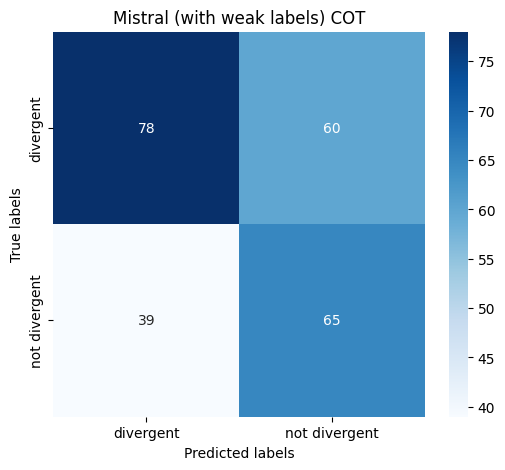

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test = test_values_df['divergent or not divergent']
y_pred = test_values_df['final_val']
cm = confusion_matrix(y_test, y_pred, labels=['divergent', 'not divergent'])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
                 xticklabels=['divergent', 'not divergent'], yticklabels=['divergent', 'not divergent'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.title('Mistral (with weak labels) COT')
plt.show()